In [1]:
import logging
import sys
import datetime
import pickle
from icecream import ic
from tqdm import tqdm
from sklearn.decomposition import PCA
import seaborn as sns


In [2]:
# for correct lstm shape - https://www.kaggle.com/code/imegirin/multivariate-time-series-modeling-with-pytorch

In [3]:
from torch.utils.data import TensorDataset

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt;
np.random.seed(42);
from sklearn.metrics import roc_auc_score;

In [5]:
from sklearn.metrics import roc_auc_score;
from sklearn.metrics import classification_report;

In [6]:
pd.set_option('display.max_columns', None);

In [7]:
df=pd.read_pickle('appmath.pkl')[['graph_id', 'user_id', 
       'goal_id',
        'interaction_end_time',
       'learning_objective_name', 'atom_id', 
       'correct', 'time_spent_answering_s', 'time_spent_on_instruction_s',
       'goal_progress',
       'target_status_and_progress', 'prev_concept_narrative',
       'duration_s', 'is_target']]  

In [8]:
df2=pd.read_csv('prereq_edges.csv')

In [9]:
G=nx.Graph()

for _,i in df2.iterrows():    
       
        G.add_edge(i['source_lo_title'],i['dest_lo_title'])
        
subgraphs=[G.subgraph(i) for i in nx.connected_components(G)]

for num,sub in enumerate(subgraphs):
    
    nx.set_node_attributes(sub,num,'subGraphId')

nodeSubGraphId={}
for g in subgraphs:
    for node in g.nodes(data=True):
         nodeSubGraphId[node[0]]= node[1]['subGraphId']
            
subgraphsNodeCountDict={ num: g.number_of_nodes() for num,g in  enumerate(subgraphs)}

In [10]:
for col in df.columns:
    if df[col].dtype.name=='category':
        df[col]=df[col].astype(str)

In [11]:
df['loGraphID']=df.learning_objective_name.apply(lambda x: nodeSubGraphId.get(x) )

In [12]:
difficulty=df[~df.correct.isna()].groupby('atom_id')['correct'].mean().reset_index().rename(columns={'correct':'difficulty'})
df=df.merge(difficulty,how='left',on='atom_id')

In [13]:
lo_difficulty=df[~df.correct.isna()].groupby('learning_objective_name')['correct'].mean().reset_index().rename(columns={'correct':'lo_difficulty'})
df=df.merge(lo_difficulty,how='left',on='learning_objective_name')


In [14]:
def atomClassifier(x):
    if x==None:
        return 'learningMaterial'
    else:
        return 'question'

In [15]:
df['atom_type']=df.correct.apply(lambda x:atomClassifier(x) )

In [16]:
df['correctBinary']=df.correct*1
df.atom_id=df.atom_id.astype(str)


In [17]:
df=df[~df.correctBinary.isna()]

In [18]:
df2['graph_id']=df2.apply(lambda x: nodeSubGraphId.get(x['source_lo_title']) if nodeSubGraphId.get(x['source_lo_title'])!=None else nodeSubGraphId.get(x['dest_lo_title']),axis=1)

In [19]:
unique_lo_graph_id_dic={}
for i in df2.graph_id.unique():
    unique_lo=np.unique(np.concatenate((df2[df2.graph_id==i]['source_lo_title'].unique(),((df2[df2.graph_id==i]['dest_lo_title'].unique())))))
    unique_lo_graph_id_dic[i]={ item:int(num)  for  num,item in enumerate(unique_lo)}
    df2.loc[df2.graph_id==i,'source_index' ]=df2.apply(lambda x: unique_lo_graph_id_dic.get(i).get(x['source_lo_title']),axis=1)
    df2.loc[df2.graph_id==i,'dest_index' ]=df2.apply(lambda x: unique_lo_graph_id_dic.get(i).get(x['dest_lo_title']),axis=1)

In [20]:
df2.source_index=df2.source_index.astype(int)
df2.dest_index=df2.dest_index.astype(int)

In [21]:
df=df[~df.loGraphID.isna()]

In [22]:
#df['loIndex']=df.apply(lambda x: unique_lo_graph_id_dic[x['loGraphID']].get(x['learning_objective_name'] ),axis=1)

In [23]:
df2[df2.graph_id==3].max()

source_lo_id                    eda7ab6a-8070-4fd8-8387-da17a40fd99e
dest_lo_id                      eda7ab6a-8070-4fd8-8387-da17a40fd99e
source_lo_title    Write biconditional statements in symbolic for...
dest_lo_title      Write biconditional statements in symbolic for...
graph_id                                                           3
source_index                                                      30
dest_index                                                        30
dtype: object

In [24]:
summary=df.pivot_table(index='goal_id',aggfunc={'learning_objective_name':pd.Series.nunique,'atom_id':pd.Series.nunique,'user_id':pd.Series.nunique,'interaction_end_time':np.count_nonzero})

In [25]:
summary['atom_usage']=summary.interaction_end_time/summary.atom_id

In [26]:
summary.sort_values('atom_usage',ascending=False).head(10)

,atom_id,interaction_end_time,learning_objective_name,user_id,atom_usage
goal_id,,,,,
39f38cfd-d153-4fcf-950e-5c1b2bfbeaaa,72,8793,3,289,122.125000
d252b7df-6a57-46ff-b4c3-e21d26d80b6a,82,9887,5,253,120.573171
cd26c1cb-87ad-4b57-bdeb-7e8811827e39,59,5764,3,194,97.694915
86940cba-2a55-43a6-8f51-248afca9952d,26,1974,1,291,75.923077
caacf0e3-8698-4806-8ce8-a45d8f75b587,59,4396,3,240,74.508475
12b7f97f-18be-4a9e-9384-866a036631d4,103,7107,5,260,69.000000
9059c88d-ccdd-42dd-a19f-fe7c9bafd6aa,47,3236,2,255,68.851064
46e93a47-9de8-4982-82ec-6e3acb911c54,116,7116,6,240,61.344828
917d2bb2-451f-4f65-8eec-7a8125c9a596,39,2220,2,140,56.923077


In [273]:
loGraphID=3
user=df[df.loGraphID==loGraphID].user_id.sample(5).values

dfg=df[(df.loGraphID==loGraphID) & (df.user_id.isin(user)) ].reset_index(drop=True)
dfg.shape

(929, 19)

In [274]:
dfg.atom_id.nunique()

427

In [275]:
dfg=dfg.sort_values(['user_id','interaction_end_time'])

In [276]:
atom_index={atom_id:i for i,atom_id  in  enumerate(dfg.atom_id.unique())}

In [277]:
dfg['atomIndex']=dfg.atom_id.map(atom_index)

In [278]:
loEdgeMapping=df2[df2['graph_id']==loGraphID][['source_index','dest_index']]
lo_edges=loEdgeMapping.values.transpose()

In [279]:
lo_map=pd.concat([df2[df2['graph_id']==loGraphID][['source_lo_title','source_index']].rename(columns={'source_lo_title':'learning_objective_name','source_index':'loIndex'}),df2[df2['graph_id']==loGraphID][['dest_lo_title','dest_index']].rename(columns={'dest_lo_title':'learning_objective_name','dest_index':'loIndex'})]).drop_duplicates().reset_index(drop=True)

In [280]:
dfg['atomIndex']=dfg.atom_id.map(atom_index)

In [281]:
#loIndex={lo:i for i,lo in enumerate( dfg.learning_objective_name.unique())}
#dfg['loIndex']=dfg['learning_objective_name'].apply(lambda x: loIndex[x])

In [282]:
dfg=dfg.merge(lo_map,on='learning_objective_name',how='left')

In [283]:
dfg

,graph_id,user_id,goal_id,interaction_end_time,learning_objective_name,atom_id,correct,time_spent_answering_s,time_spent_on_instruction_s,goal_progress,target_status_and_progress,prev_concept_narrative,duration_s,is_target,loGraphID,difficulty,lo_difficulty,atom_type,correctBinary,atomIndex,loIndex
0,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,07ce41ed-31d4-418a-97c4-380fdf7cedb6,05a24526-bd1a-46a1-baf0-b85b29adf64a,2022-09-26 23:48:04.881,Identify and negate simple statements,038f2107-3e8a-4bd7-9980-884dc4854ac9,False,19.837999,6.091,0.020365,{'5310af35-3169-4538-a1c9-3a4933b680cd': {'pro...,DIRECT_CHOOSE_TOPIC,25.928999,True,3.0,0.678030,0.581220,question,0,0,17
1,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,07ce41ed-31d4-418a-97c4-380fdf7cedb6,05a24526-bd1a-46a1-baf0-b85b29adf64a,2022-09-27 20:29:45.242,Identify and negate quantified statements,a3e3ad80-e479-4c76-b1fe-2818be405810,False,25.375999,6.457,0.019558,{'5310af35-3169-4538-a1c9-3a4933b680cd': {'pro...,DIRECT_DIAGNOSE_TOPIC,31.833000,True,3.0,0.595402,0.486775,question,0,1,16
2,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,07ce41ed-31d4-418a-97c4-380fdf7cedb6,05a24526-bd1a-46a1-baf0-b85b29adf64a,2022-09-27 20:29:57.539,Identify and negate simple statements,1eeff0fa-d2d7-4bd0-bd6e-9cb9c94cf9ed,True,10.485000,1.606,0.099856,{'5310af35-3169-4538-a1c9-3a4933b680cd': {'pro...,DIRECT_DIAGNOSE_TOPIC,12.091000,True,3.0,0.890411,0.581220,question,1,2,17
3,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,07ce41ed-31d4-418a-97c4-380fdf7cedb6,05a24526-bd1a-46a1-baf0-b85b29adf64a,2022-09-27 20:30:15.750,Identify and negate quantified statements,52f227a2-174b-4817-951d-d05bd830bd53,False,14.369000,3.649,0.091533,{'5310af35-3169-4538-a1c9-3a4933b680cd': {'pro...,DIRECT_DIAGNOSE_TOPIC,18.018000,True,3.0,0.625668,0.486775,question,0,3,16
4,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,07ce41ed-31d4-418a-97c4-380fdf7cedb6,05a24526-bd1a-46a1-baf0-b85b29adf64a,2022-09-27 20:30:25.088,Identify and negate simple statements,0f9006e5-26de-4ae8-b6f9-5603c805303d,False,6.088000,3.067,0.061832,{'5310af35-3169-4538-a1c9-3a4933b680cd': {'pro...,DIRECT_DIAGNOSE_TOPIC,9.155000,True,3.0,0.714286,0.581220,question,0,4,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,c959f9ac-125b-42fe-a43a-8ee41c8f0766,5b1889ca-a0ae-48ba-9076-fe94eca8bb21,2022-10-19 21:28:39.964,Determine if a syllogistic argument is valid w...,db4827ba-deb1-4357-b967-3c647e99fb69,True,5.811000,1.686,0.994518,{'965861e5-3166-4577-95da-2c7795504318': {'pro...,DIRECT_PRE_TEST,7.497000,True,3.0,0.867647,0.612136,question,1,223,8
925,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,c959f9ac-125b-42fe-a43a-8ee41c8f0766,5b1889ca-a0ae-48ba-9076-fe94eca8bb21,2022-10-19 21:29:01.080,Determine if a syllogistic argument is valid w...,7e420426-e419-4767-ba78-1c9e4e82774a,False,12.396000,8.501,0.948407,{'965861e5-3166-4577-95da-2c7795504318': {'pro...,DIRECT_PRE_TEST,20.896999,True,3.0,0.651685,0.612136,question,0,222,8
926,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,c959f9ac-125b-42fe-a43a-8ee41c8f0766,5b1889ca-a0ae-48ba-9076-fe94eca8bb21,2022-10-19 21:29:19.371,Determine if a syllogistic argument is valid w...,129ffb21-1cab-4d36-b809-a2831e0c3f20,True,15.888000,2.197,0.975756,{'965861e5-3166-4577-95da-2c7795504318': {'pro...,DIRECT_PRE_TEST,18.084999,True,3.0,0.813253,0.612136,question,1,207,8
927,076e1a0e-669c-40c4-a23c-7ac2bbaa05cf,c959f9ac-125b-42fe-a43a-8ee41c8f0766,5b1889ca-a0ae-48ba-9076-fe94eca8bb21,2022-10-19 21:29:28.979,Determine if a syllogistic argument is valid w...,088a7a3b-b75e-46e6-bed0-743d2908d3d1,True,7.859000,1.529,0.994532,{'965861e5-3166-4577-95da-2c7795504318': {'pro...,DIRECT_TEACH,9.388000,True,3.0,0.536585,0.612136,question,1,217,8


In [284]:
question_sequence=dfg[['loIndex','atomIndex','correctBinary']].values.transpose()

In [285]:
lo_atom_edges_list=dfg.groupby(['loIndex','atomIndex'])['graph_id'].nunique().index.to_list()

In [286]:
question_sequence_len=question_sequence.shape[1]



In [287]:
l1,l2=zip(*lo_atom_edges_list)


In [288]:
lo_atom_edges=np.array((list(l1),list(l2)))

In [289]:
#loFeatures=dfg.groupby('loIndex')['lo_difficulty'].mean().values.reshape(-1,1)
atomFeatures=dfg.groupby('atomIndex')['difficulty'].mean().values.reshape(-1,1)
loFeatures=np.zeros(31 ).reshape(-1,1)

In [290]:
from torch_geometric.data import HeteroData
import torch 


In [291]:
data = HeteroData()

In [292]:
data['atom'].x=torch.tensor(atomFeatures.astype(np.float64)).float()
#data['atom'].y=torch.tensor(atomFeatures.astype(np.float64)).float()
data['lo'].x= torch.tensor(loFeatures.astype(np.float64)).float()

In [293]:
data['lo','lo_atom','atom'].edge_index=torch.from_numpy(lo_atom_edges).long()
data['lo','lo_lo','lo'].edge_index=torch.from_numpy(lo_edges).long()

In [294]:
import torch_geometric.transforms as T

In [295]:
normalize=T.NormalizeFeatures()
data=normalize(data)

In [296]:
import torch_geometric as pyg
from torch_geometric.nn import GCNConv 
from torch_geometric.nn import SAGEConv, to_hetero ,LSTMAggregation
import  torch.nn as nn
import torch.nn.functional as F
import torch 
from torch_geometric.loader import DataLoader

In [297]:
data.metadata()

(['atom', 'lo'], [('lo', 'lo_atom', 'atom'), ('lo', 'lo_lo', 'lo')])

In [298]:
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

In [299]:
hidden_channels=100
final_layer_dim=hidden_channels/4
class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels,requires_grad=True)
        self.actfn1=nn.ReLU()
        
        self.conv2 = SAGEConv((-1, -1),int( hidden_channels/2),requires_grad=True)
        self.actfn2=nn.ReLU()
        
        self.conv3 = SAGEConv((-1, -1),int( final_layer_dim),requires_grad=True)
        self.actfn3=nn.ReLU()
        
        self.conv4 = SAGEConv((-1, -1),int( hidden_channels/8),requires_grad=True)
        self.actfn4=nn.ReLU()
        
        
        self.sigmoid= nn.Sigmoid()

    def forward(self, x, edge_index):
        
        x = self.actfn1(self.conv1(x, edge_index))
        #x= F.dropout(x,p=.5,training=self.training)
        
        x = self.actfn2(self.conv2(x, edge_index))
        #x= F.dropout(x,p=.7,training=self.training)
        
        x = self.actfn3(self.conv3(x, edge_index))
        
        #out = self.actfn4(self.conv4(x, edge_index))
        
        #out= F.dropout(x,p=.7,training=self.training)
        #pool={key: gmp(out[key].x, out[key].batch) for key in out.node_types}
        #out=self.sigmoid( self.out(x))
        #ic(pool)
        
        #pool=gmp(out)
        return x

In [300]:
lookback=3
hidden_channels1=int((final_layer_dim)*2*(lookback+1)+(lookback+1))

out_channels=1
class Classifer(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.ins=nn.Linear(hidden_channels1,10)
        self.actfn1=nn.ReLU()
        
        self.ins2=nn.Linear(10,5)
        self.actfn2=nn.ReLU()
        
        self.out=nn.Linear(5,1)
        self.actfn3=nn.Sigmoid()
        
    def forward(self, x):
        
        x= self.actfn1 (self.ins(x))
        
        x= self.actfn2 (self.ins2(x))
        
        out=self.actfn3(self.out(x))
        
        
        return out

In [301]:
class GNN_Classifier(nn.Module):
    def __init__(self):
        super(GNN_Classifier, self).__init__()
        
        self.model_embedding=GNN()
        self.model_embedding = to_hetero(self.model_embedding, data.metadata(),aggr='max')
        self.classifer = Classifer()
        #lo,atom,prev_answer,prev_lo,prev_atom,prev_answer1,prev_lo1,prev_atom1
    def forward(self, x,edges,batch_num,lookback,question_sequence):
        node_embeddings = self.model_embedding(x,edges)
        rnn_input_list=[]
        features_concat_list=[]
        
        for i in range(lookback+1):
            #print([i,batch_num-i])
            lo=question_sequence[0][batch_num-i]
            atom=question_sequence[1][batch_num-i]
            prev_answer=torch.tensor([question_sequence[2][batch_num-1-i]]).float()
            
            features_concat_list.extend([node_embeddings['atom'][atom]])
            features_concat_list.extend([node_embeddings['lo'][lo]])
            features_concat_list.extend([prev_answer])
        
                                         
            
        #user_embeddings=torch.cat([node_embeddings['atom'][atom] , node_embeddings['lo'][lo],prev_answer,node_embeddings['atom'][prev_atom] , node_embeddings['lo'][prev_lo],prev_answer1,node_embeddings['atom'][prev_atom1] , node_embeddings['lo'][prev_lo1]])  
       
        user_embeddings=torch.cat(features_concat_list)
        
        rnn_outputs = self.classifer(user_embeddings)
    
        return rnn_outputs,user_embeddings

In [302]:

model=GNN_Classifier()
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=5e-12)
criterion=torch.nn.BCELoss()
#criterion=F.binary_cross_entropy
train_acc_mean_list=[]
test_acc_mean_list=[]
loss_list=[]
accuracy_list=[]
best_score=0
user_embedings=[]

loss_moving_avg=[]

for epoch_num in range(2):
    epoch_accuracy=[]
    out_list=[]
    total_loss=0
    user_embedings=[]
    prob=[]
    target=[]
    for  batch_num in range(lookback,question_sequence_len):
        
        model.train()
       
        optimizer.zero_grad()   
        #x_dict = {key: gmp(batch[key].x, batch[key].batch) for key in batch.node_types}
        

        answer=torch.tensor([question_sequence[2][batch_num]]).float()
     
        
        out,node_embeddings=model(data.x_dict, data.edge_index_dict,batch_num,lookback,question_sequence) 
        user_embedings.append((node_embeddings,answer))
        loss=F.binary_cross_entropy(out,answer)
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        total_loss=total_loss+loss.item()
        train_correct=out.round()==answer
        
        train_acc=train_correct*1
        accuracy=(train_correct*1).item()
        epoch_accuracy.append(accuracy)
        #accuracy_list.append(accuracy)
        prob.append(out.item())
        target.append(answer.item())
    performance='epoch {} | loss {:.5f} | accuracy {:.5f} | auc {:.5f}'.format(epoch_num,total_loss/(batch_num+1),np.mean(epoch_accuracy),roc_auc_score(np.array(target),prob))
    print(performance)
    loss_moving_avg.append(total_loss/(batch_num+1))
            
    #ic((epoch_num,np.mean(epoch_accuracy),loss.item()))
    

#out['target']: tensor([[0.2217, 0.0272]], grad_fn=<AddmmBackward0>)

epoch 0 | loss 0.70810 | accuracy 0.45680 | auc 0.53090
epoch 1 | loss 0.69529 | accuracy 0.45680 | auc 0.52629


In [303]:
performance

'epoch 1 | loss 0.69529 | accuracy 0.45680 | auc 0.52629'

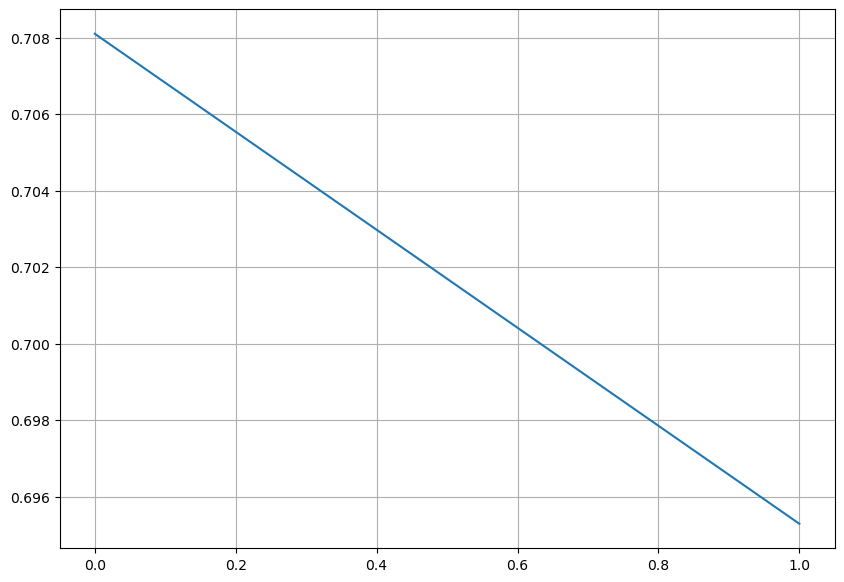

In [304]:
plt.figure(figsize=(10,7))
mvg_steps=question_sequence_len

#for i in range(len(loss_list)-mvg_steps):
#    loss_moving_avg.append(np.mean(loss_list[mvg_steps*i:(i+1)*mvg_steps]))
plt.grid()
#plt.plot(loss_list)
plt.plot(loss_moving_avg)


In [305]:
len(user_embedings)

926

In [306]:
user_embedings[0][0].shape

torch.Size([204])

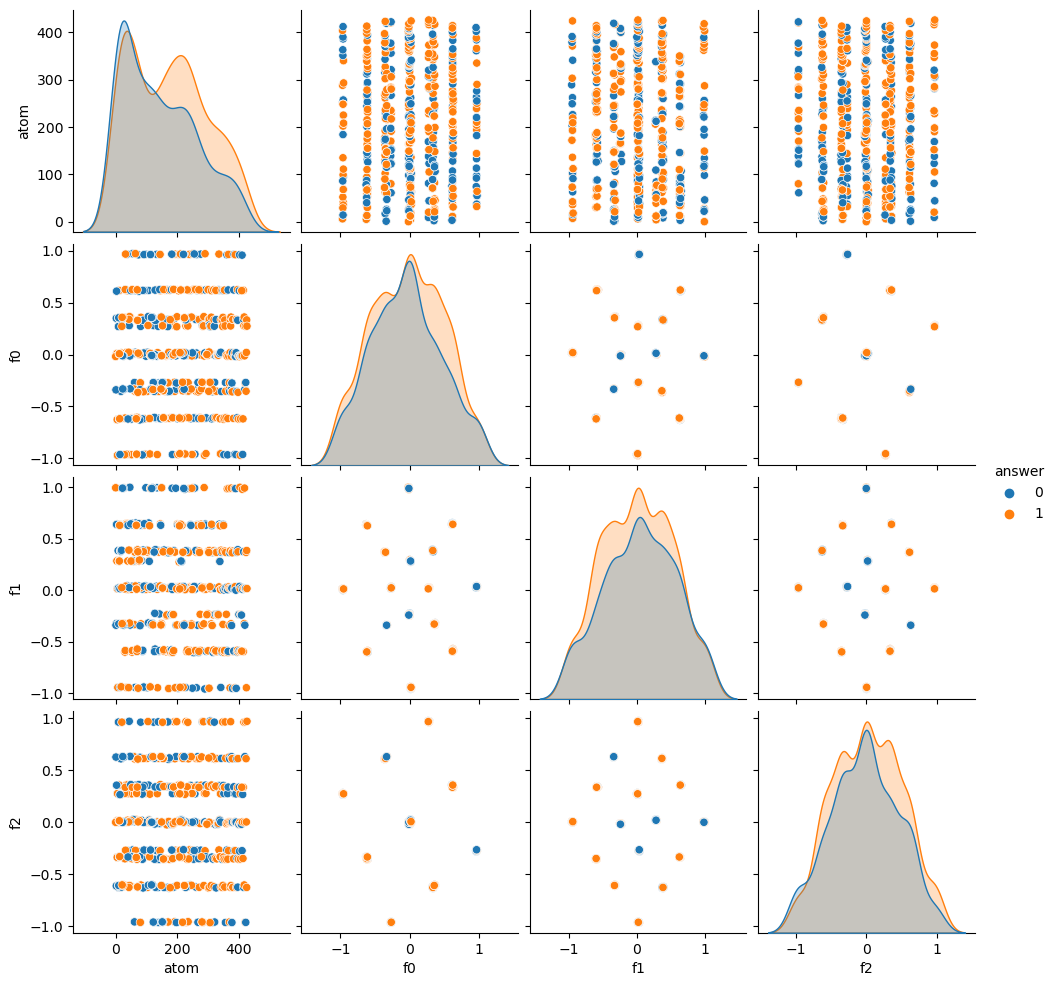

In [307]:
node_embeddings=[i[0] for i in user_embedings]

nodes=torch.stack(node_embeddings).detach().numpy()

nodesDf=pd.DataFrame(nodes[-question_sequence_len:])

pca = PCA(n_components=3)
components = pca.fit_transform(nodesDf)

#pcadf=pd.DataFrame({'f1':components[:,0],'f2':components[:,1]})
pcadf=pd.DataFrame({ 'f'+str(i):components[:,i]  for i in  range(components.shape[1]) })

answersdf=pd.DataFrame({'atom':question_sequence[1][lookback:],'answer':question_sequence[2][lookback:]})

pcadf=pcadf.reset_index().rename(columns={'index':'atom'})

answersdffea=answersdf.merge(pcadf,on='atom',how='left')

sns.pairplot(answersdffea,hue='answer')

In [308]:
hidden_channels=64
final_layer_dim=hidden_channels/4
class GNN_Lstm(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels,requires_grad=True)
        self.actfn1=nn.ReLU()
        
        self.conv2 = SAGEConv((-1, -1),int( hidden_channels/2),requires_grad=True)
        self.actfn2=nn.ReLU()
        
        self.conv3 = SAGEConv((-1, -1),int( final_layer_dim),requires_grad=True)
        self.actfn3=nn.ReLU()
        
        self.conv4 = SAGEConv((-1, -1),int( hidden_channels/8),requires_grad=True)
        self.actfn4=nn.ReLU()
        
        
        self.sigmoid= nn.Sigmoid()

    def forward(self, x, edge_index):
        
        x = self.actfn1(self.conv1(x, edge_index))
        #x= F.dropout(x,p=.5,training=self.training)
        
        x = self.actfn2(self.conv2(x, edge_index))
        #x= F.dropout(x,p=.7,training=self.training)
        
        x = self.actfn3(self.conv3(x, edge_index))
        
        #out = self.actfn4(self.conv4(x, edge_index))
        
        #out= F.dropout(x,p=.7,training=self.training)
        #pool={key: gmp(out[key].x, out[key].batch) for key in out.node_types}
        #out=self.sigmoid( self.out(x))
        #ic(pool)
        
        #pool=gmp(out)
        return x

In [309]:
lookback=3
input_size=33
out_channels=1
num_layers=1
hidden_size=20
class Classifer_Lstm(nn.Module):
    
    def __init__(self ):
        super().__init__()
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        self.sigmoid=nn.Sigmoid()
        
        self.lstm = nn.LSTM(
            input_size=self.input_size ,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self,x):
        #print(x.shape)
        h0 = torch.zeros(self.num_layers, 1, self.hidden_size).requires_grad_()
        # Initialize long-term memory
        c0 = torch.zeros(self.num_layers, 1, self.hidden_size).requires_grad_()
        # Pass all inputs to lstm layer
        out, _ = self.lstm(x, (h0, c0))
        #print(out.shape)
        out = self.sigmoid(self.fc(out[:, -1, :]))
        
        return out

In [310]:
class GNN_LSTM_Classifier(nn.Module):
    def __init__(self):
        super(GNN_LSTM_Classifier, self).__init__()
        
        self.model_embedding=GNN_Lstm()
        self.model_embedding = to_hetero(self.model_embedding, data.metadata(),aggr='max')
        self.classifer = Classifer_Lstm()
        #lo,atom,prev_answer,prev_lo,prev_atom,prev_answer1,prev_lo1,prev_atom1
    def forward(self, x,edges,batch_num,lookback,question_sequence):
        node_embeddings = self.model_embedding(x,edges)
        rnn_input_list=[]
        #features_concat_list=[]
        
        for i in range(lookback+1):
            
            #print([i,batch_num-i])
            lo=question_sequence[0][batch_num-i]
            atom=question_sequence[1][batch_num-i]
            prev_answer=torch.tensor([question_sequence[2][batch_num-1-i]]).float()

            features_concat=torch.cat([node_embeddings['atom'][atom],node_embeddings['lo'][lo],prev_answer])
            rnn_input_list.append(features_concat)
        
                                         
            
        #user_embeddings=torch.cat([node_embeddings['atom'][atom] , node_embeddings['lo'][lo],prev_answer,node_embeddings['atom'][prev_atom] , node_embeddings['lo'][prev_lo],prev_answer1,node_embeddings['atom'][prev_atom1] , node_embeddings['lo'][prev_lo1]])  
       
        rnn_input_stacked=torch.stack(rnn_input_list).view(1,lookback+1,features_concat.shape[0])

        rnn_outputs = self.classifer(rnn_input_stacked)
    
        return rnn_outputs,node_embeddings

In [311]:

model=GNN_LSTM_Classifier()
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=5e-12)
criterion=torch.nn.BCELoss()
#criterion=F.binary_cross_entropy
train_acc_mean_list=[]
test_acc_mean_list=[]
loss_list=[]
accuracy_list=[]
best_score=0


loss_moving_avg=[]
user_embedings=[]
for epoch_num in range(75):
    epoch_accuracy=[]
    out_list=[]
    total_loss=0
    
    prob=[]
    target=[]
    for  batch_num in range(lookback,question_sequence_len):
        
        model.train()
       
        optimizer.zero_grad()   
        #x_dict = {key: gmp(batch[key].x, batch[key].batch) for key in batch.node_types}
        

        answer=torch.tensor([question_sequence[2][batch_num]]).float()
     
        
        out,node_embeddings=model(data.x_dict, data.edge_index_dict,batch_num,lookback,question_sequence) 
        
        loss=F.binary_cross_entropy(out.view(1),answer)
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        total_loss=total_loss+loss.item()
        train_correct=out.round()==answer
        
        train_acc=train_correct*1
        accuracy=(train_correct*1).item()
        epoch_accuracy.append(accuracy)
        #accuracy_list.append(accuracy)
        prob.append(out.item())
        target.append(answer.item())
    performance='epoch {} | loss {:.5f} | accuracy {:.5f} | auc {:.5f}'.format(epoch_num,total_loss/(batch_num+1),np.mean(epoch_accuracy),roc_auc_score(np.array(target),prob))
    print(performance)
    loss_moving_avg.append(total_loss/(batch_num+1))
            
    #ic((epoch_num,np.mean(epoch_accuracy),loss.item()))
    

#out['target']: tensor([[0.2217, 0.0272]], grad_fn=<AddmmBackward0>)

epoch 0 | loss 0.68744 | accuracy 0.55076 | auc 0.51434
epoch 1 | loss 0.68798 | accuracy 0.54104 | auc 0.49912
epoch 2 | loss 0.68702 | accuracy 0.53672 | auc 0.50665
epoch 3 | loss 0.68521 | accuracy 0.55616 | auc 0.51852
epoch 4 | loss 0.68373 | accuracy 0.56156 | auc 0.52795
epoch 5 | loss 0.68265 | accuracy 0.56048 | auc 0.53985
epoch 6 | loss 0.68189 | accuracy 0.56587 | auc 0.55337
epoch 7 | loss 0.68127 | accuracy 0.56371 | auc 0.55601
epoch 8 | loss 0.67979 | accuracy 0.56048 | auc 0.57164
epoch 9 | loss 0.66495 | accuracy 0.57559 | auc 0.61327
epoch 10 | loss 0.65686 | accuracy 0.60043 | auc 0.64272
epoch 11 | loss 0.64470 | accuracy 0.62635 | auc 0.66693
epoch 12 | loss 0.63720 | accuracy 0.62203 | auc 0.68007
epoch 13 | loss 0.63189 | accuracy 0.62851 | auc 0.68742
epoch 14 | loss 0.63122 | accuracy 0.62743 | auc 0.68395
epoch 15 | loss 0.62554 | accuracy 0.62527 | auc 0.68760
epoch 16 | loss 0.62029 | accuracy 0.63175 | auc 0.69470
epoch 17 | loss 0.61661 | accuracy 0.6447

In [312]:
performance

'epoch 74 | loss 0.44160 | accuracy 0.77106 | auc 0.86638'

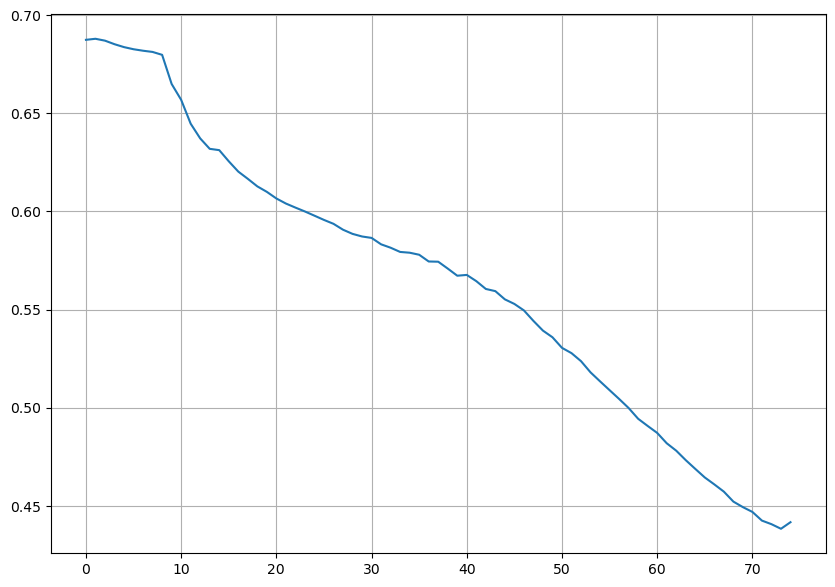

In [313]:
plt.figure(figsize=(10,7))
mvg_steps=question_sequence_len

#for i in range(len(loss_list)-mvg_steps):
#    loss_moving_avg.append(np.mean(loss_list[mvg_steps*i:(i+1)*mvg_steps]))
plt.grid()
#plt.plot(loss_list)
plt.plot(loss_moving_avg)


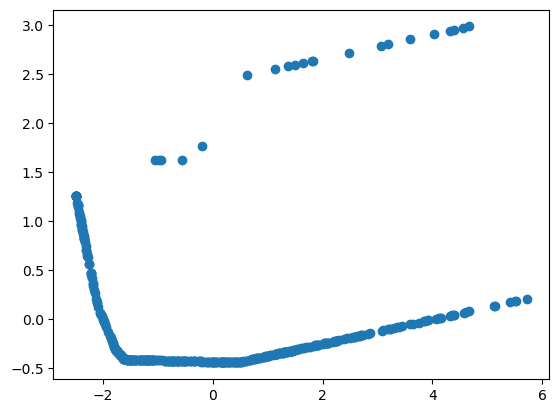

In [314]:
atoms=node_embeddings['atom'].detach().numpy()
pca = PCA(n_components=3)
components = pca.fit_transform(atoms)
plt.scatter(components[:,0],components[:,1])

In [315]:
los=node_embeddings['lo'].detach().numpy()
pca = PCA(n_components=3)
components1 = pca.fit_transform(los)


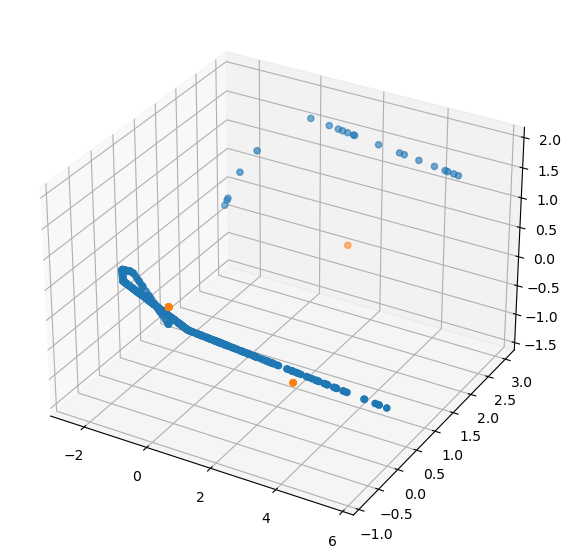

In [316]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')

ax.scatter(components[:,0], components[:,1], components[:,2]);
ax.scatter(components1[:,0], components1[:,1], components1[:,2] );

In [332]:
seq_features=[]
for i in range(3,question_sequence_len):
    seq_features.append(torch.cat([node_embeddings['atom'][question_sequence[1][i]].detach(),
                                   #node_embeddings['lo'][question_sequence[0][i]].detach(),
                                   #torch.tensor([question_sequence[-1][i-1]]),
                                   
                                    node_embeddings['atom'][question_sequence[1][i-1]].detach(),
                                   #node_embeddings['lo'][question_sequence[0][i-1]].detach(),
                                   #torch.tensor([question_sequence[-1][i-2]]),
                                   
                                    node_embeddings['atom'][question_sequence[1][i-2]].detach(),
                                   #node_embeddings['lo'][question_sequence[0][i-2]].detach(),
                                   #torch.tensor([question_sequence[-1][i-3]])
                                  
                                  
                                  ]).numpy())

In [344]:

#first_user_sq_length=dfg[dfg.user_id==dfg.user_id.unique()[0]].shape[0]
first_user_sq_length=0
second_user_sq_length=dfg[dfg.user_id==dfg.user_id.unique()[1]].shape[0]

In [345]:
np.stack(seq_features ).shape

(926, 48)

In [346]:
pca = PCA(n_components=3)
components2 = pca.fit_transform(np.stack(seq_features )[first_user_sq_length:first_user_sq_length+second_user_sq_length])


In [347]:
question_sequence[-1][3:first_user_sq_length+3].shape

(0,)

In [348]:
components2.shape

(57, 3)

In [349]:
pcadf=pd.DataFrame({ 'f'+str(i):components2[:,i]  for i in  range(components2.shape[1]) })


pcadf['answers']=question_sequence[-1][3:second_user_sq_length+3]



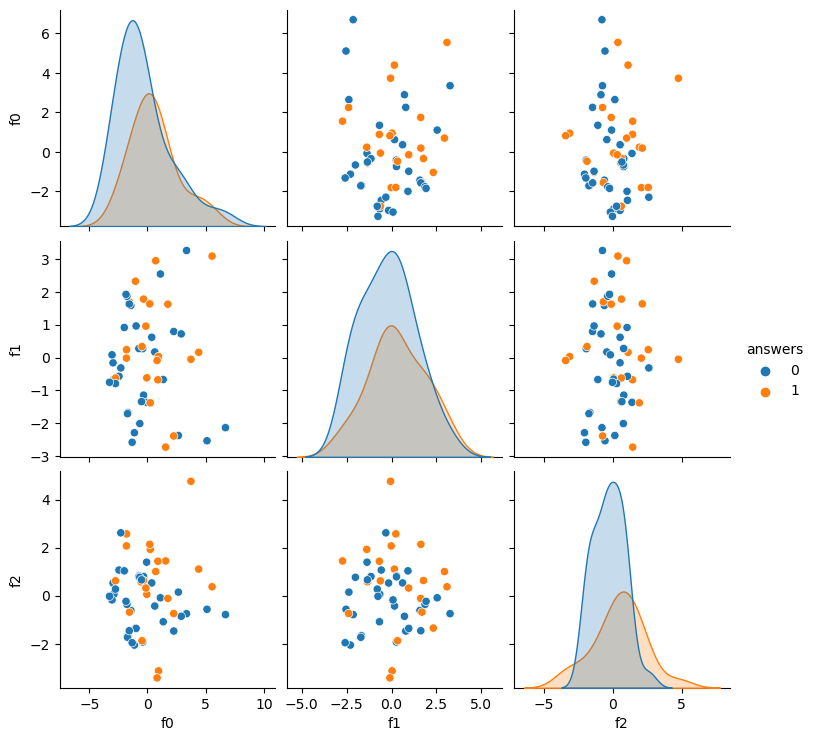

In [350]:
   
sns.pairplot(pcadf,hue='answers')
plt.show() 

In [351]:
from matplotlib.animation import FFMpegWriter, PillowWriter

In [352]:
metadata = dict( artist='codinglikemad')
# writer = PillowWriter(fps=15, metadata=metadata)
writer = FFMpegWriter(fps=10, metadata=metadata)

In [353]:
plt.rcParams['animation.ffmpeg_path'] = "C:\\research\\ffmpeg-4.4-full_build\\bin\\ffmpeg.exe"

In [354]:
fig = plt.figure(figsize=(100,100))
ax = plt.axes(projection='3d')
correct=pcadf[pcadf.answers==1]
falls=pcadf[pcadf.answers==0]
#ax.set_xlabel('f0')
#ax.set_ylabel('f1')
#ax.set_zlabel('f2')
#ax.scatter3D(correct.iloc[:,1], correct.iloc[:,2], correct.iloc[:,0],label='correct');
#ax.scatter3D(falls.iloc[:,1], falls.iloc[:,2], falls.iloc[:,0],label='wrong');
#plt.legend()
S=2000
with writer.saving(fig, "exp3d.gif", 10):
    for i in range(0,361,1):
        print(i)
        ax.set_xlabel('f0')
        ax.set_ylabel('f1')
        ax.set_zlabel('f2')
        ax.scatter3D(correct.iloc[:,1], correct.iloc[:,2], correct.iloc[:,0],label='correct',s=S);
        ax.scatter3D(falls.iloc[:,1], falls.iloc[:,2], falls.iloc[:,0],label='wrong',s=S);
        plt.legend(markerscale=.5)
        
        ax.view_init(30, i);

        writer.grab_frame()
        plt.cla()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

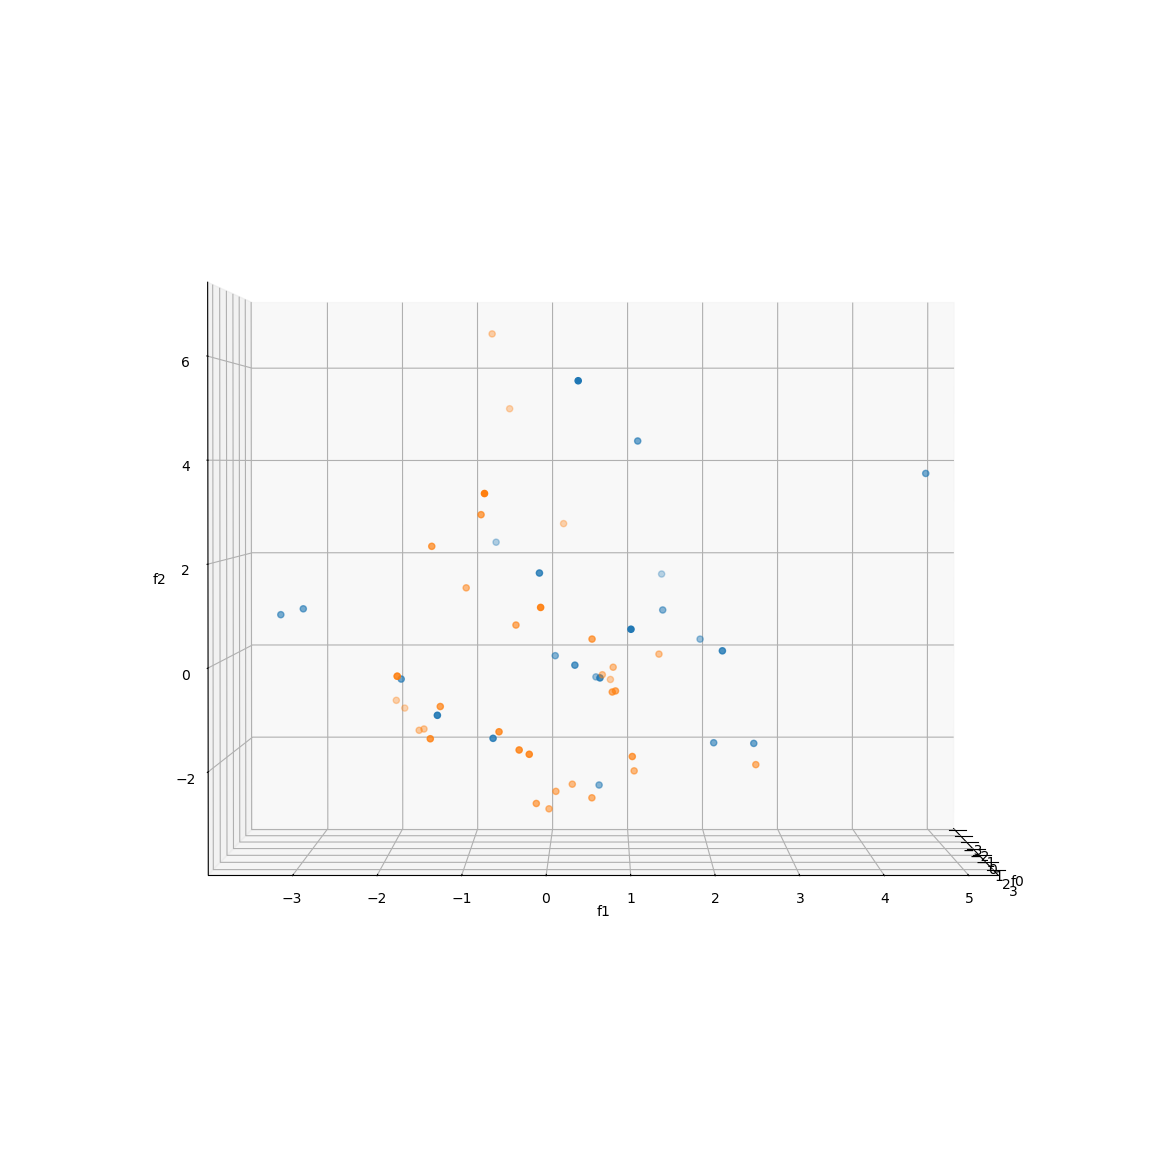

In [355]:

#fig = plt.figure()

def animate(angle):
    ax.view_init(30, angle)
#animate(10)
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
correct=pcadf[pcadf.answers==1]
falls=pcadf[pcadf.answers==0]
   
for i in range(1,360,72):
    ax.set_xlabel('f0')
    ax.set_ylabel('f1')
    ax.set_zlabel('f2') 
    ax.scatter3D(correct.iloc[:,1], correct.iloc[:,2], correct.iloc[:,0],label='correct');
    ax.scatter3D(falls.iloc[:,1], falls.iloc[:,2], falls.iloc[:,0],label='wrong');
    #plt.legend()
    ax.view_init(i, 0);
    #ax.draw();
    plt.pause(.001);
    ax.cla()
#ani = FuncAnimation(fig, animate, frames=range(360))
   
  
    

In [356]:
animate(20)

In [357]:
falls.mean()

f0        -0.357875
f1        -0.197534
f2        -0.280679
answers    0.000000
dtype: float64